In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import streamlit as st


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import  cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
import seaborn as sns
import sklearn
from scipy.stats import randint, uniform
from imblearn.over_sampling import RandomOverSampler
import joblib
from sklearn.metrics import classification_report
print(sklearn.__version__)

1.3.0


In [3]:
# Load your dataset (replace 'your_dataset.csv' with your actual dataset)
dataset = pd.read_csv('card_transdata.csv')
dataset.head()



,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
# This will count all columns, assuming there is no designated target column you want to exclude
number_of_features = dataset.shape[1]

# If you know the target column and want to exclude it from the count
number_of_features_excluding_target = dataset.shape[1] - 1  # adjust as necessary

print("Number of features:", number_of_features)
print("Number of features excluding target:", number_of_features_excluding_target)


Number of features: 8
Number of features excluding target: 7


In [5]:
# number of columns
print(f'# columns: {dataset.shape[1]}')

# number of rows
print(f'# rows: {dataset.shape[0]}')

# columns: 8
# rows: 1000000


In [6]:
dataset['fraud'] = dataset['fraud'].astype(str)

In [7]:
#Obtain the value counts and print them. We reset the index to make this a bit easier to plot.
fraud_v_counts = dataset['fraud'].value_counts().reset_index()

#Rename the columns of this (now) dataset. 
fraud_v_counts.columns = ['Fraud', 'Value_Count']

#Recode the type, again, for plotting. Here, I will just rename the column values as well.
col_values = ['Not Fraud', 'Is Fraud']
fraud_v_counts['Fraud'] = col_values

print(f"Number of Fraud: {fraud_v_counts['Value_Count'][1]}\nNumber of NOT Fraud: {fraud_v_counts['Value_Count'][0]}")
print(f"The ratio between the two is: " \
f"{fraud_v_counts['Value_Count'][1]/(fraud_v_counts['Value_Count'][1]+fraud_v_counts['Value_Count'][0])} Fraud, " \
f"{fraud_v_counts['Value_Count'][0]/(fraud_v_counts['Value_Count'][1]+fraud_v_counts['Value_Count'][0])} Not Fraud")

Number of Fraud: 87403
Number of NOT Fraud: 912597
The ratio between the two is: 0.087403 Fraud, 0.912597 Not Fraud


In [8]:
dataset.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')

In [9]:
dataset.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [10]:
duplicate_rows = dataset[dataset.duplicated()]
print("Duplicate rows:")
print(duplicate_rows)

Duplicate rows:
Empty DataFrame
Columns: [distance_from_home, distance_from_last_transaction, ratio_to_median_purchase_price, repeat_retailer, used_chip, used_pin_number, online_order, fraud]
Index: []


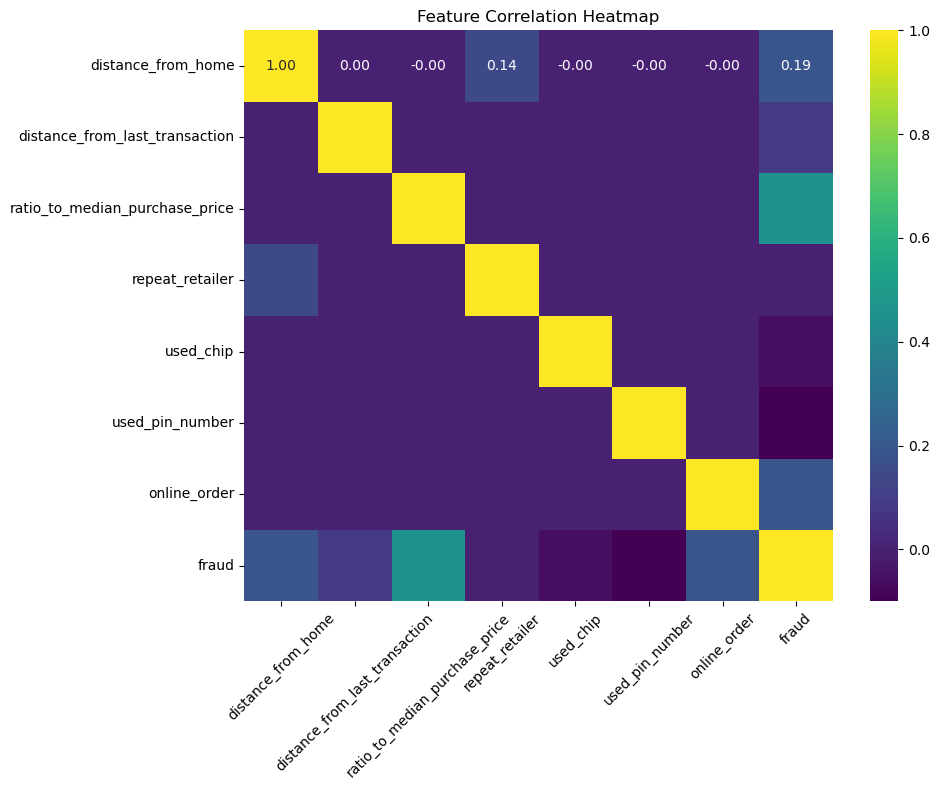

In [11]:
corr = dataset.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))  # Adjusted size for better visibility
sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis', annot_kws={'size': 10})  # Increased font size for annotations
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.yticks(rotation=0)  # Adjust y labels rotation if necessary
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [12]:
# Correlations with fraud
corr = dataset.corr()['fraud'].sort_values(ascending = False)
corr = corr.to_frame()
corr.style.background_gradient(cmap="RdYlBu")

,fraud
fraud,1.000000
ratio_to_median_purchase_price,0.462305
online_order,0.191973
distance_from_home,0.187571
distance_from_last_transaction,0.091917
repeat_retailer,-0.001357
used_chip,-0.060975
used_pin_number,-0.100293


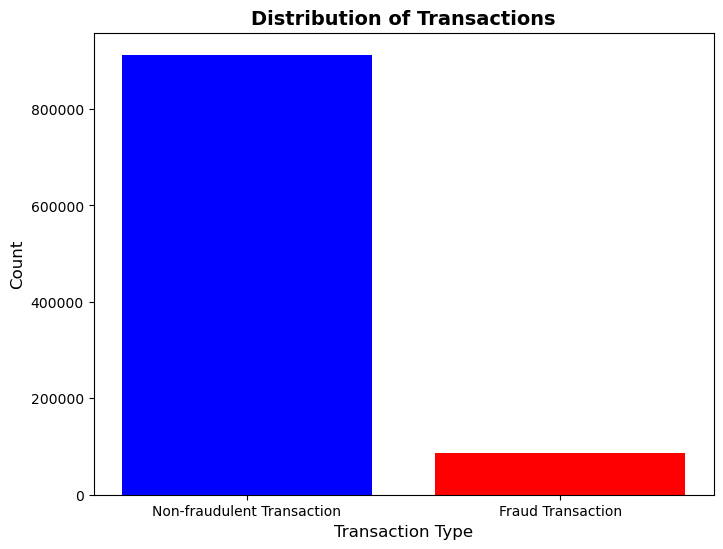

In [13]:
# Replace label 0.0 with 'Non-Fraudulent Transaction' and 1 with 'Fraud Transaction'
fraud_labels = dataset['fraud'].replace({0.0: 'Non-Fraudulent Transaction', 1: 'Fraud Transaction'})

# Count the occurrences of each label
fraud_counts = dataset['fraud'].value_counts()


# Replace the pie chart with a bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Non-fraudulent Transaction', 'Fraud Transaction'], dataset['fraud'].value_counts(), color=['blue', 'red'])
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Transactions', fontsize=14, weight='bold')
plt.show()



We have 91.26% of Non-fraudulent transactions (912,597) and only 8.74% (87,403) of fraud transactions!

Because the data in the fraud variable is imbalanced,  undersampling or oversampling techniques to solve this problem

**DATA PROCESSING**

In [14]:
#1. Removing Outliers
print(f' The number of samples before removing outliers: {dataset.shape[0]}')

 The number of samples before removing outliers: 1000000


In [15]:
# Create a list containing numerical features
num_features = ['distance_from_home', 'online_order', 'ratio_to_median_purchase_price']

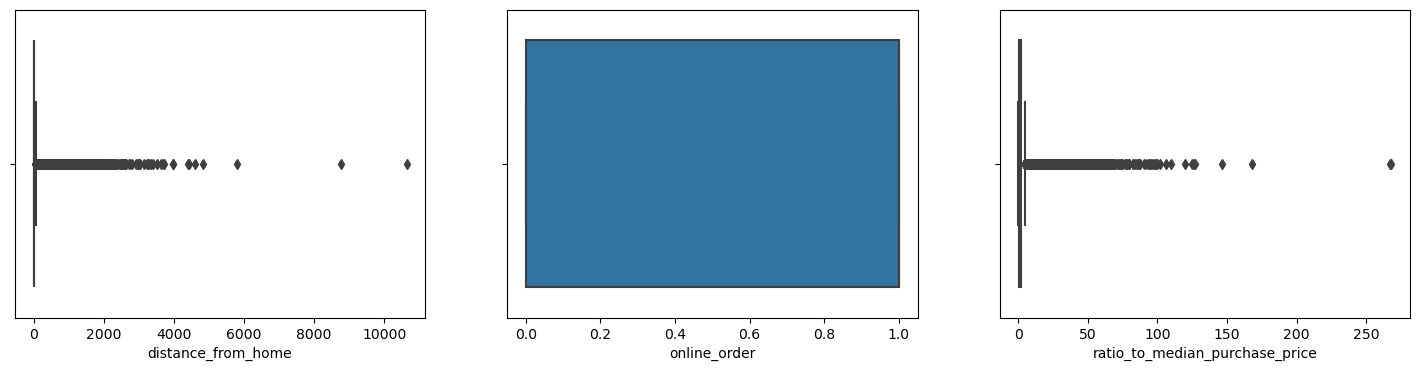

In [16]:
# Drawing a boxplot to display the distribution of each numerical column to detect the outliers
plt.figure(figsize = (18, 4))
for i, col in enumerate(num_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data = dataset, x = col)
plt.show()

In [17]:
# Remove outliers
def remove_outliers(df, col):
    
    # 1st quartile (25%)
    Q1 = df[col].quantile(0.25)
    # 3rd quartile (75%)
    Q3 = df[col].quantile(0.75)
    
    # Interquartile range (IQR)
    IQR = Q3 - Q1    
    
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

In [18]:
dataset_no_outliers = dataset.copy()
for col in num_features:
    dataset_no_outliers = remove_outliers(dataset_no_outliers, col)

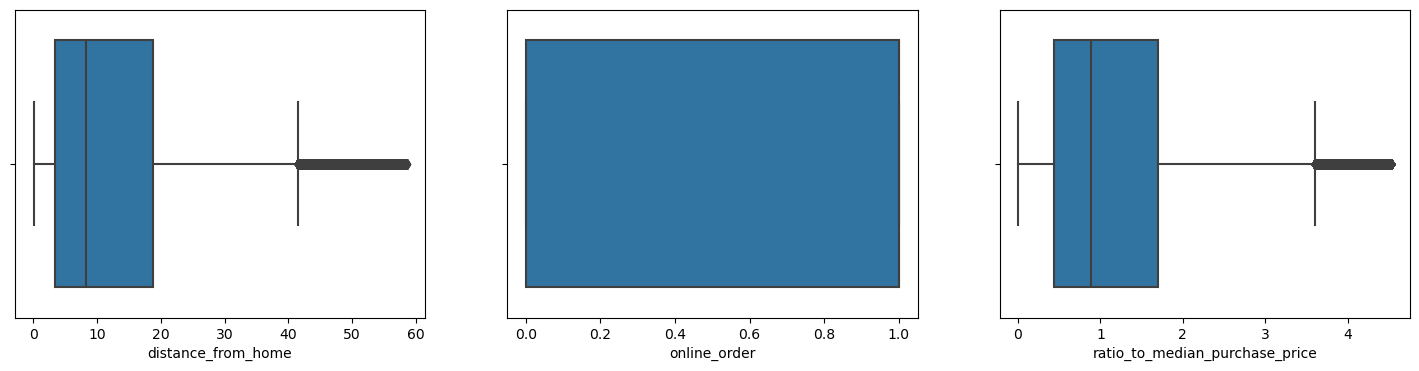

In [19]:
# Drawing a boxplot to display the distribution of each numerical column after removing the outliers
plt.figure(figsize = (18, 4))
for i, col in enumerate(num_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data = dataset_no_outliers, x = col)
plt.show()

In [20]:
print(f' The number of samples after removing outliers: {dataset_no_outliers.shape[0]}')

 The number of samples after removing outliers: 820687


In [21]:
# Assuming your dataset is named 'dataset'
# Sample size you want to reduce to
sample_size = 10000  # You can adjust this value as needed

# Randomly select a subset of rows from the original dataset
sampled_dataset = dataset.sample(n=sample_size, random_state=42)

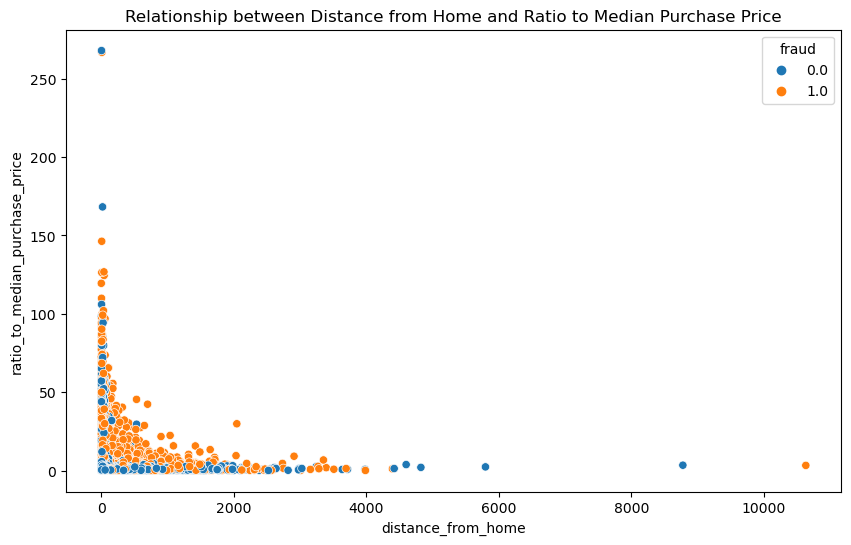

In [22]:
# Plotting specific relationships
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dataset, x='distance_from_home', y='ratio_to_median_purchase_price', hue='fraud')
plt.title('Relationship between Distance from Home and Ratio to Median Purchase Price')
plt.show()


In [23]:
# Define numerical features
num_features = ['distance_from_home', 'online_order', 'ratio_to_median_purchase_price']

# Split dataset into features and target variable
X = sampled_dataset[num_features]
y = sampled_dataset['fraud']

# Convert target variable to integer format
y = y.astype(float).astype(int)

from imblearn.over_sampling import SMOTE

# Performing train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Applying SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)








In [24]:
# Feature Importance with XGBoost
xgb = XGBClassifier(objective='binary:logistic', random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)
importances = xgb.feature_importances_
features_df = pd.DataFrame(list(zip(num_features, importances)), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Display feature importances
print(features_df)

                          Feature  Importance
1                    online_order    0.521930
2  ratio_to_median_purchase_price    0.328817
0              distance_from_home    0.149252


In [25]:
from imblearn.under_sampling import RandomUnderSampler

# Define the undersampler
#rus = RandomUnderSampler(random_state=42)

# Apply the undersampler to the training data
#X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

# Now, X_train_undersampled and y_train_undersampled have a balanced class distribution


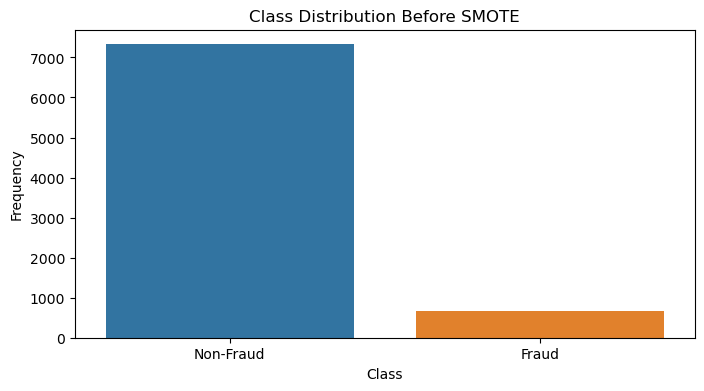

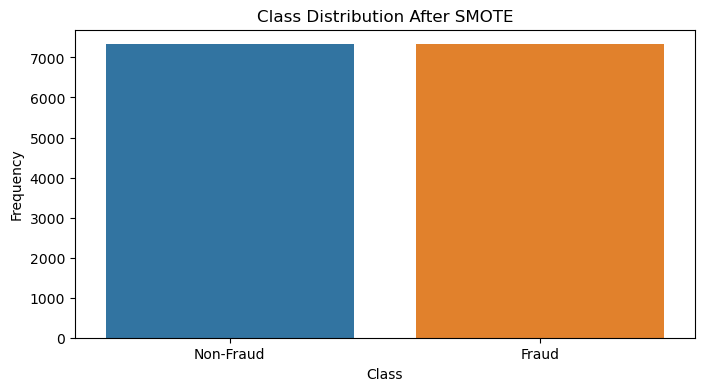

In [26]:
# Visualizing class distribution before and after SMOTE
def plot_class_distribution(y, title):
    labels = ['Non-Fraud' if x == 0 else 'Fraud' for x in y]
    df = pd.DataFrame({'Class': labels})
    plt.figure(figsize=(8, 4))
    sns.countplot(x='Class', data=df)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

plot_class_distribution(y_train, 'Class Distribution Before SMOTE')
plot_class_distribution(y_train_resampled, 'Class Distribution After SMOTE')

In [27]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from joblib import dump

# Classifier definitions with pipelines
classifiers = {
    'Random Forest': Pipeline([
        ('scaler', MinMaxScaler()),
        ('feature_selection', SelectFromModel(RandomForestClassifier( random_state=42))),
        ('classifier', RandomForestClassifier (random_state=42))
    ]),
    'MLP Classifier': Pipeline([
        ('scaler', MinMaxScaler()),  # Ensuring non-negative values for chi-squared test
        ('feature_selection', SelectKBest(chi2, k=2)),
        ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42))
    ]),
    'Logistic Regression': Pipeline([
        ('scaler', MinMaxScaler()),  # Logistic regression also benefits from feature scaling
        ('feature_selection', SelectKBest(chi2, k=3)),  # Adjust k based on how many features you want to select
        ('classifier', LogisticRegression(random_state=42))
    ])
}

param_grids = {
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10],
        'classifier__min_samples_split': [2, 5]
    },
    'MLP Classifier': {
        'classifier__hidden_layer_sizes': [(50,), (100,)],
        'classifier__alpha': [0.0001, 0.001]
    },
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10]
    }
}

# Train and save each classifier
best_estimators = {}
metrics_results = {}
for name, pipeline in classifiers.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_estimators[name] = grid_search.best_estimator_
    # Save each model
    #model_path = f'C:/Users/Dell/Desktop/finalproject/{name.replace(" ", "_")}_model.pkl'
    #joblib.dump(best_estimators, model_path)
    #print(f"{name} model trained and saved.")
for name, estimator in best_estimators.items():
    model_path = f'C:/Users/Dell/Desktop/finalproject/{name.replace(" ", "_")}_model.pkl'
    dump(estimator, model_path)
    print(f"{name} model trained and saved.")






Random Forest model trained and saved.
MLP Classifier model trained and saved.
Logistic Regression model trained and saved.


In [28]:
scaler = StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_train_resampled)

# Save the trained scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

C:\Users\Dell\anaconda3\envs\project\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



Classifier: Random Forest
Accuracy: 0.9215
Precision: 0.4666666666666667
Recall: 0.04487179487179487
F1 Score: 0.08187134502923978
ROC AUC Score: 0.5202667000389344
Confusion Matrix:
 [[1836    8]
 [ 149    7]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1844
           1       0.47      0.04      0.08       156

    accuracy                           0.92      2000
   macro avg       0.70      0.52      0.52      2000
weighted avg       0.89      0.92      0.89      2000

Cross-Validation Scores for Random Forest: [0.86352781 0.86421017 0.85904437 0.86723549 0.86075085]
Mean Cross-Validation Score for Random Forest: 0.8629537380222944

Classifier: MLP Classifier
Accuracy: 0.9405
Precision: 0.9302325581395349
Recall: 0.2564102564102564
F1 Score: 0.4020100502512563
ROC AUC Score: 0.627391679181267
Confusion Matrix:
 [[1841    3]
 [ 116   40]]
              precision    recall  f1-score   support

           0       0.94      1

C:\Users\Dell\anaconda3\envs\project\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Cross-Validation Scores for MLP Classifier: [0.8304333  0.85226885 0.85494881 0.86211604 0.8662116 ]
Mean Cross-Validation Score for MLP Classifier: 0.8531957199897995

Classifier: Logistic Regression
Accuracy: 0.923
Precision: 0.6666666666666666
Recall: 0.02564102564102564
F1 Score: 0.04938271604938271
ROC AUC Score: 0.512278213471272
Confusion Matrix:
 [[1842    2]
 [ 152    4]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1844
           1       0.67      0.03      0.05       156

    accuracy                           0.92      2000
   macro avg       0.80      0.51      0.50      2000
weighted avg       0.90      0.92      0.89      2000

Cross-Validation Scores for Logistic Regression: [0.89286933 0.89150461 0.90682594 0.90887372 0.90546075]
Mean Cross-Validation Score for Logistic Regression: 0.90110686867346


C:\Users\Dell\anaconda3\envs\project\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


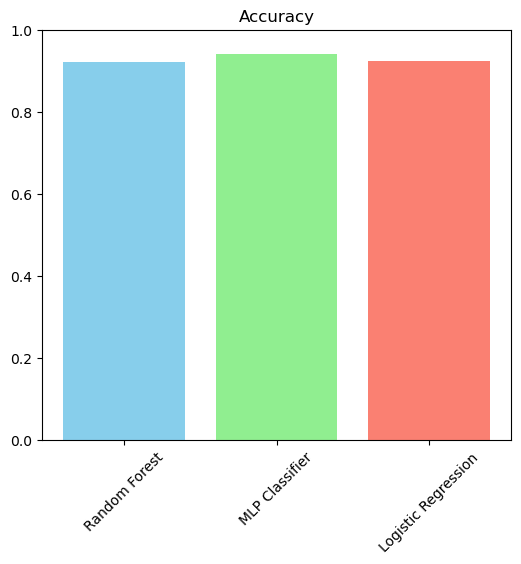

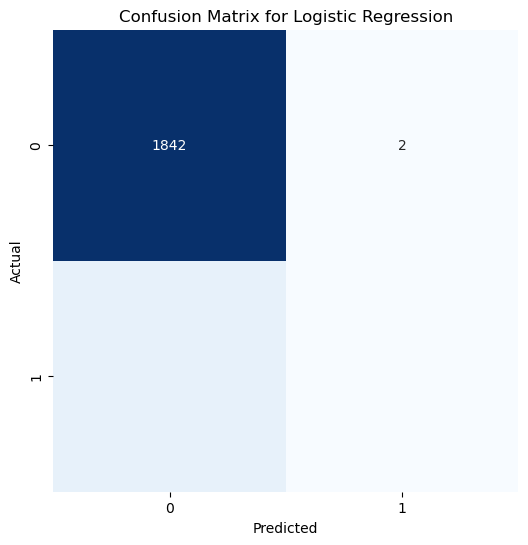

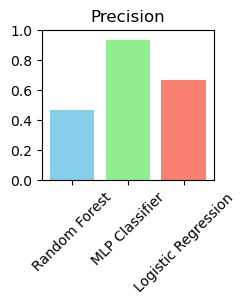

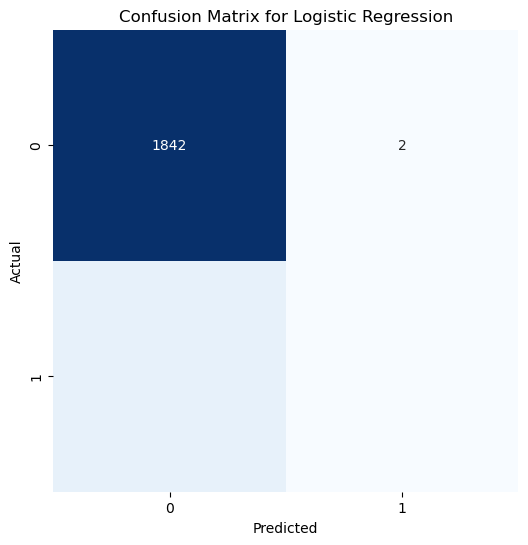

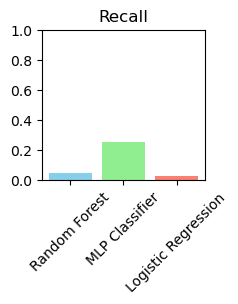

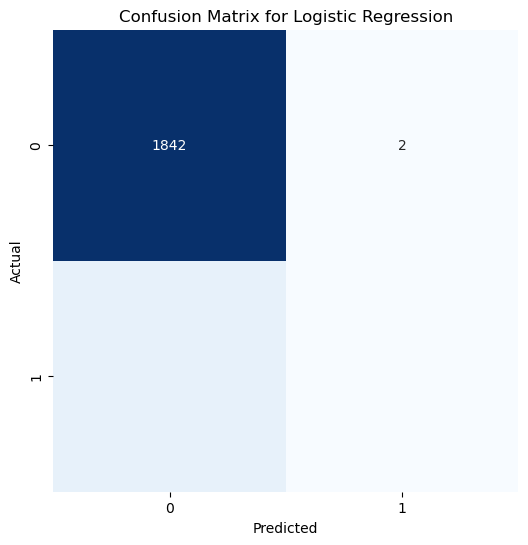

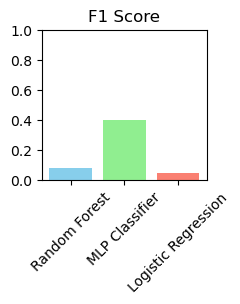

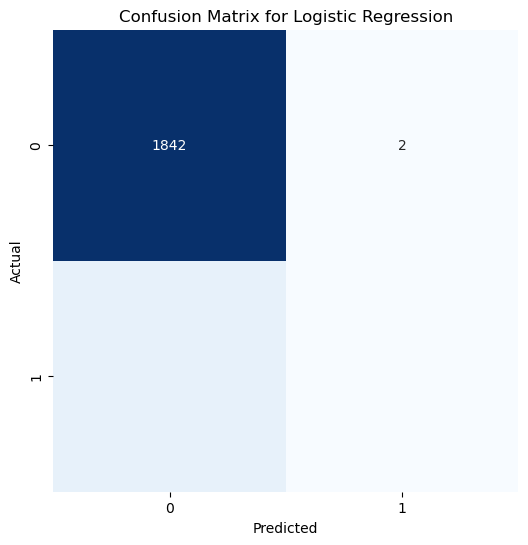

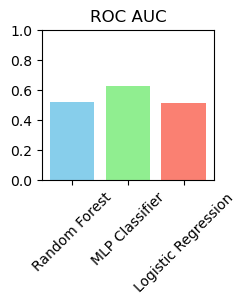

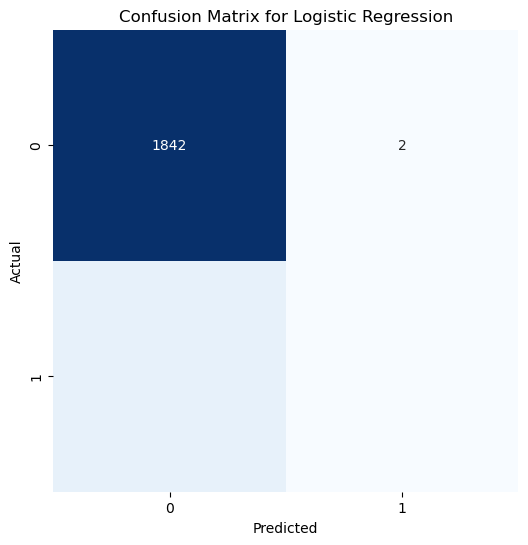

In [37]:
 # Evaluate models and collect metrics
for name, estimator in best_estimators.items():
    y_pred = estimator.predict(X_test_scaled)  # Ensure you're using the correct test set
    metrics_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Print results for each classifier
    print(f"\nClassifier: {name}")
    print("Accuracy:", metrics_results[name]['Accuracy'])
    print("Precision:", metrics_results[name]['Precision'])
    print("Recall:", metrics_results[name]['Recall'])
    print("F1 Score:", metrics_results[name]['F1 Score'])
    print("ROC AUC Score:", metrics_results[name]['ROC AUC'])
    print("Confusion Matrix:\n", metrics_results[name]['Confusion Matrix'])
    print(classification_report(y_test, y_pred))

    # Perform cross-validation
    cross_val_scores = cross_val_score(estimator, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    print(f"Cross-Validation Scores for {name}: {cross_val_scores}")
    print(f"Mean Cross-Validation Score for {name}: {np.mean(cross_val_scores)}")

# Plotting the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    scores = [metrics_results[name][metric] for name in best_estimators.keys()]
    plt.bar(best_estimators.keys(), scores, color=['skyblue', 'lightgreen', 'salmon'])
    plt.title(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()



C:\Users\Dell\anaconda3\envs\project\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


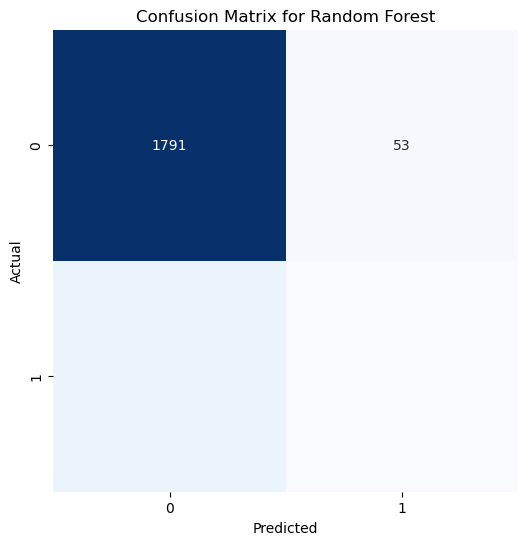

C:\Users\Dell\anaconda3\envs\project\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


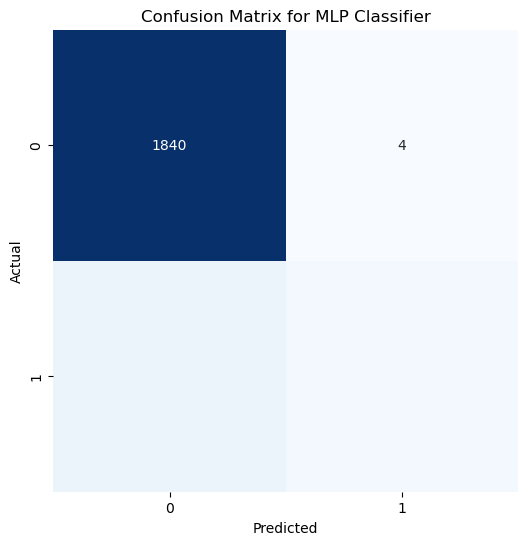

C:\Users\Dell\anaconda3\envs\project\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


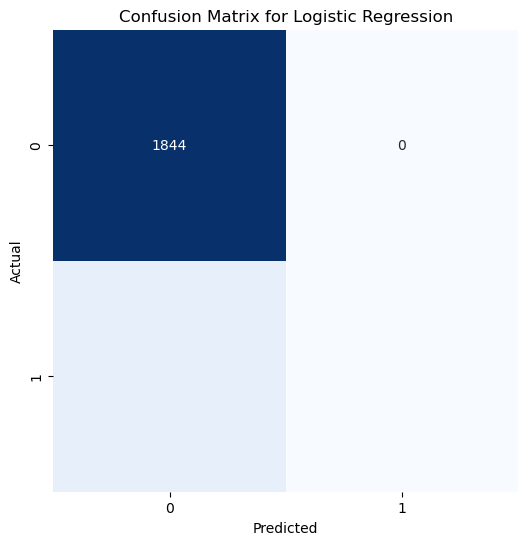

In [36]:
for name, pipeline in classifiers.items():
    pipeline.fit(X_train_resampled, y_train_resampled)
    y_pred = pipeline.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

In [31]:
import pandas as pd

# Convert arrays to DataFrame/Series
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=['distance_from_home', 'online_order', 'ratio_to_median_purchase_price'])  # Adjust column names accordingly
y_train_resampled_df = pd.Series(y_train_resampled, name='Target')


In [32]:
# Export to CSV
# Concatenate features and target along columns
#resampled_data2 = pd.concat([X_train_resampled_df, y_train_resampled_df], axis=1)



In [33]:
# Check the first few rows to ensure the DataFrame looks correct
#print(resampled_data2.head())


In [34]:
# Export to CSV without index
#resampled_data2.to_csv('resampled_data4.csv', index=False)


In [35]:

#streamlit run C:\Users\Dell\anaconda3\envs\project\lib\site-packages\ipykernel_launcher.py
